# Goal

We'd like to learn a little more about how you practically approach a small research-like project loosely based on Rejection Sampling Fine-tuning (aka RFT, introduced in https://arxiv.org/abs/2308.01825).

Tip: focus on section 3.3 ("Rejection Sampling Fine-tuning"). The paper isn't the best written, and we're happy to clarify anything.

We will provide some skeleton code for you to guide what we would like to see from you, although if you have ideas for a different structure you feel is better or more elegant, then feel free to rewrite and replace at will.

Note: your final submission does not have to be in a colab notebook, does not have to use Hugging Face, etc.

---


We want to give you a chance to show off some of your best abilities.

For some people that might mean generating high quality data in a smart way. For others, it might be speeding up the whole process to enable easy reproducibility, and maybe organizing the code in a better way than given. Yet for others, it might be a chance to show off some modern policy optimization techniques like DPO or its variants. Or maybe focusing on solid evaluations and identifying limitations of small models and limited fine-tuning.

An ideal outcome of course is some sense of the model improving its mathematical abilities, but it’s not a bad thing if the final evaluation somehow shows equal or worse performance 😂 (negative results are results).

Ask lots of question! We're happy to answer any questions about the assignment, and to discuss concepts like RFT.

# Setup [ignore - just run]
***

In [1]:
#!pip3 install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import os  
import torch
import random 
import datasets
import numpy as np 
import pandas as pd

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from torch.utils.data import DataLoader

from data import GSM8KDataset, _apply_template
from prompt import EvalTemplate, EvalTemplateExp

import utils
import generation 

import seaborn as sns 

os.environ["TOKENIZERS_PARALLELISM"] = "true"
SEED = 128 
MODEL_NAME = "microsoft/Phi-3.5-mini-instruct"

# set seeds
torch.random.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.bfloat16, # accelerate inf 
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = datasets.load_dataset('gsm8k', 'main')['train']
val_dataset = datasets.load_dataset('gsm8k', 'main')['test'] 
print(f"Num Training instances: {train_dataset.shape[0]}")
print(f"Num Validation instances: {val_dataset.shape[0]}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Num Training instances: 7473
Num Validation instances: 1319


# Dataset
****
- The reasoning paths/hops seem to present in seperate lines (leading to easiniess in parsing them)
- The equaiton tags ```<< >>``` are used to train language models to invoke calculators in the original GSM8K OpenAI paper.
- **Verified that our ```utils.GSM8KParser.get_answer_from_pred``` is parsing the same result as the ground truth parser**

## Inspection 

In [5]:
train_dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [6]:
for _ in range(5):
    seed = np.random.randint(0, len(train_dataset))
    print("*"*100)
    print(f"Checking instance {seed}:")
    utils.inspect_instance(train_dataset, seed)

****************************************************************************************************
Checking instance 3282:
question
It’s February 2021.  Mark was born in January 1976.  Graham is 3 years younger than Mark, and Graham’s sister, Janice, is 1/2 the age of Graham.  How old is Janice?
answer
It’s 2021 and Mark was born in 1976 so Mark is 2021-1976 = <<2021-1976=45>>45 years old
Graham is 3 years younger than Mark who is 45 so Graham is 45-3 = 42 years old
Janice is 1/2 the age of Graham who is 42 so Janice is 42/2 = <<42/2=21>>21 years old
#### 21
**************************************************
****************************************************************************************************
Checking instance 7251:
question
Melissa sells a coupe for $30,000 and an SUV for twice as much. If her commission is 2%, how much money did she make from these sales?
answer
First find the total cost of the SUV: $30,000 * 2 = $<<30000*2=60000>>60,000
Then add the cost of the coup

## Extract statistics 

We only look at train set now for certain information that will be used
during inference 

- Maximum length (num_tokens) of question: 239
- Maximum length (num_tokens) of answer: 475 

In [7]:
train_dataset = train_dataset.map(
    lambda x: utils.GSM8KParser.get_question_length(x['question'], tokenizer)
)

train_dataset = train_dataset.map(
    lambda x: utils.GSM8KParser.get_answer_length(x['answer'], tokenizer) 
)
print(f"Maximum answer num_tokens: {max(train_dataset['answer_length'])}")
print(f"Maximum question num_tokens: {max(train_dataset['question_length'])}")

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Maximum answer num_tokens: 475
Maximum question num_tokens: 239


## Extract Answer 

In [8]:
# infer number of hops 
train_dataset = train_dataset.map(
    lambda x: utils.GSM8KParser.get_num_hops(x['answer'])
)

# infer answes using ground truth parser 
train_dataset = train_dataset.map(
    lambda x: utils.GSM8KParser.get_answer_from_gt(x['answer'])
)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [9]:
# Optinal Cell (Only to verify that parsing from 
# ground truth and parsing from completion would 
# yield the same result 
# infer answers using prediction parser
answer_str_inf = [
    utils.GSM8KParser.get_answer_from_pred(x)['answer_str_digit'] \
    for x in train_dataset['answer']
]
assert answer_str_inf == train_dataset['answer_str_digit']

# A note on the collate function 
***
Instead of tokenizing the dataset using ```collate_fn``` on the fly. I went for pre-tokenzing the dataset into a static format, avoiding the need to tokenzie data on the fly. This would lead to faster training runs, but less flexibility in terms of handling data on the fly. i.e. If you want to slightly modify the quesiton conditional on the model performance during training, it's impossible to do it without a collate function.

However, since our problem is simple, we can afford to pre-tokenize the dataset.

That said, there is a dummy collation function ```class PreprocessedCollator(DataCollatorMixin)``` in ```lora.py```, simply offloading the input to format required by SFTTRainer. 

Inside ```data.py```, the tokenization is done in the ```GSM8KDataset``` class, which runs a ````self._preprocess```` function on instentiation. 

All required attributes, i.e. input_ids, attention_mask, labels are prepared once instentiation completes. For detailed explanation, please refer to ```data.GSM8KDataset._preprocess```. 

If we refers to ```data.GSM8KDataset``` class, you could find that the output schema is rather long, which could result in taking up nunecessary spaces during training, further engineering effort could be inplace to remediate that. 


In [10]:
train_dataset = datasets.load_dataset('gsm8k', 'main')['train']
train_dataset = train_dataset.map(
    lambda x: utils.GSM8KParser.get_num_hops(x['answer'])
)
TrainData = GSM8KDataset(train_dataset, tokenizer) #Complete tokenization of the dataset

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Maximum question num_tokens: 359
Maximum answer num_tokens: 477
Maximum sequence num_tokens: 836
Maximum new tokens in generation: 527


Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Setup Completed dataset:
Dataset({
    features: ['question', 'answer', 'num_hops', 'answer_str_digit', 'formatted_question', 'formatted_answer', 'question_length', 'answer_length', 'question_input_ids', 'question_attention_mask', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 7473
})


In [11]:
val_dataset = datasets.load_dataset('gsm8k', 'main')['test'] 
val_dataset = val_dataset.map(
    lambda x: utils.GSM8KParser.get_num_hops(x['answer'])
)
valData = GSM8KDataset(val_dataset, tokenizer)

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Maximum question num_tokens: 310
Maximum answer num_tokens: 430
Maximum sequence num_tokens: 740
Maximum new tokens in generation: 480


Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Setup Completed dataset:
Dataset({
    features: ['question', 'answer', 'num_hops', 'answer_str_digit', 'formatted_question', 'formatted_answer', 'question_length', 'answer_length', 'question_input_ids', 'question_attention_mask', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1319
})


## Validation 

* We wanted to validate that our mannual padding is done correctly 

### Data Loader Compatibility

In [12]:
dummy_dataloader = DataLoader(TrainData, batch_size=2, shuffle=False)
for batch in dummy_dataloader:
    assert batch['input_ids'].shape[0] == 2
    assert (batch['input_ids'] == TrainData[:2]['input_ids']).all()
    break 
# first we validated that it's loading a homugenous batch of data

### Padding for the entire sequence (training)

In [13]:
instance = TrainData[0]
# check (attention mask == 1) part for the entire sequence
print(tokenizer.decode(
    instance["input_ids"][instance['attention_mask']!=0]
))

<|system|> You are a highly intelligent assistant who is exceptional at solving Math Problems.<|end|><|user|> *Task*    
Think step by step to solve the following question:
NOTE:
1. Reason deductively.
1. Write all equations in a single line wihtout breaks in the middle.
2. Submit final answer using PURE DIGITS, in the last starting with "####".
    i.e. "#### 10" if the final answer is $10

```question
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
```<|end|><|assistant|> Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72<|end|><|endoftext|>


In [14]:
# check (labels!= -100) part for the entire sequence
print(tokenizer.decode(
    instance["input_ids"][instance['labels']!=-100]
))
# noticed how loss is not measured on <|assistant|>, it belongs to part of the question 

Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72<|end|><|endoftext|>


### Padding for the question only (inference)

In [15]:
# check (attention_mask = 1) part for the question 
print(tokenizer.decode(
    instance["question_input_ids"][instance["question_attention_mask"]!=0]
))
# noticed how the question_input_ids only include everything up to <|assistant>| 

<|system|> You are a highly intelligent assistant who is exceptional at solving Math Problems.<|end|><|user|> *Task*    
Think step by step to solve the following question:
NOTE:
1. Reason deductively.
1. Write all equations in a single line wihtout breaks in the middle.
2. Submit final answer using PURE DIGITS, in the last starting with "####".
    i.e. "#### 10" if the final answer is $10

```question
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
```<|end|><|assistant|>


# Model Vibe Check 
*** 

* Test the "easiest" and the "hardest" instances from GSM8K, ranked according to the number of hops 
required to solve the problem 

* Noticed that the equation parser `GSM8KParser.parse_equations_from_pred` is not perfectly working, but it can extract sequences of numers and operatiing signs inside each lines of the text. Still giving us information about the numerical operations that has been performed. 

* Whether we should include text when parsing the eqaution is a question that we could investigate 
(In different cases, we could see the advantage and disadvantage of both )

## Generation Config

In [16]:
generation_config = {
    "max_new_tokens" : 1024,
    "temperature": 0.2, 
    "num_return_sequences":1,
    "top_p": 0.9,
    "eos_token_id":tokenizer.eos_token_id,  # Specify the EOS token
    "pad_token_id":tokenizer.eos_token_id, 
    "do_sample":True,
    "output_scores":False,
    "return_dict_in_generate":True,
}
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): Phi3ForCausalLM(
    (model): Phi3Model(
      (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-31): 32 x Phi3DecoderLayer(
          (self_attn): Phi3FlashAttention2(
            (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
            (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
            (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
          )
          (mlp): Phi3MLP(
            (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
            (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
            (activation_fn): SiLU()
          )
          (input_layernorm): Phi3RMSNorm()
          (resid_attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
          (post_attention_layernorm): Phi3RMSNorm()
        )

## Generate instances 

#### Shortest hop required instance
- An example where parsing without text could extract more relevant information 

In [17]:
## question that would need to be solved by the shortest hope 
sorted_data = sorted(TrainData, key=lambda x: x["num_hops"])
instance = sorted_data[0]

chats = [instance["formatted_question"]]
responses = utils.sample_answers(
    tokenizer,
    model,
    chats,
    **generation_config,
)
print(responses[0])

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Natalia sold clips to 48 friends in April and half as many in May, which means she sold 48/2 = 24 clips in May. To find the total number of clips sold in April and May, we add the two amounts together: 48 (April) + 24 (May) = 72. Therefore, the final answer is ####72.


In [18]:
answer = instance["answer_str_digit"] 
prediction =  utils.GSM8KParser.get_answer_from_pred(responses[0])["answer_str_digit"]

print(f"Prediction -> {prediction}")
print(f"Label -> {answer}")

Prediction -> 72
Label -> 72


In [19]:
parsed_eqs = utils.GSM8KParser.parse_equations_from_pred(responses[0])
print(parsed_eqs["equations"])
## the parser will keep looks for the previous digits before the equal sign until it stops,
## which could be clamping all numbers and operational signs in a single line together 

['4848/2=2448+24=7272']


In [20]:
parsed_eqs = utils.GSM8KParser.parse_equations_from_pred(responses[0], include_text=True)
print(parsed_eqs["equations"])
## including the text could boil down to using the entire sequence, which is undesired 

['48 friends in April and half as many in May, which means she sold 48/2 = 24 clips in May. To find the total number of clips sold in April and May, we add the two amounts together: 48 (April) + 24 (May) = 72. Therefore, the final answer is ####72']


### Longest hop required instnace
- An example where parsing including text around the formula works better 

In [21]:
# longest answer 
instance = sorted_data[-1]

chats = [instance["question"]]
responses = utils.sample_answers(
    tokenizer,
    model,
    chats,
    **generation_config,
)
print(responses[0])

To solve this problem, we need to follow these steps:

1. Determine the number of male and female students based on the given ratio and total number of students.
2. Calculate the number of male and female students who like to play basketball.
3. Find the total number of students who like to play basketball.
4. Calculate the number of students who do not like to play basketball.
5. Determine the percentage of students who do not like to play basketball out of the total student population.

Let's go through these steps:

Step 1: Determine the number of male and female students.
The ratio of male to female students is 3:2, and there are 1000 students in total. To find out how many are male and how many are female, we can use the ratio:

Total parts = 3 (male) + 2 (female) = 5 parts
Each part represents 1000 / 5 = 200 students.

So, there are:
Male students = 3 parts * 200 students/part = 600 male students
Female students = 2 parts * 200 students/part = 400 female students

Step 2: Calcula

In [22]:
answer = instance["answer_str_digit"] 
prediction =  utils.GSM8KParser.get_answer_from_pred(responses[0])["answer_str_digit"]

print(f"Prediction -> {prediction}")
print(f"Label -> {answer}")

Prediction -> <INVALID_ANSWER>
Label -> 52


In [32]:
parsed_eqs = utils.GSM8KParser.parse_equations_from_pred(responses[0])["equations"]

# noticed how in this case the *100% is not captured 
for equation in parsed_eqs:
    print(equation)

400+80=480
1000-480=520
2/3*600=400
3*200/=600
1000/5=200
520/1000*100=52
2*200/=400
1/5*400=80
3+2=5


In [31]:
parsed_eqs = utils.GSM8KParser.parse_equations_from_pred(responses[0], include_text=True)["equations"]
# this time a text-inclusive parser provides much better extraction in terms of 
# numerical operations required, as well as units, augmenting the amount of reasoning 
# related information captured 
for equation in parsed_eqs:
    print(equation)

2/3 * 600 = 400
(520 / 1000) * 100% = 52
1000 / 5 = 200
400 + 80 = 480
1000 - 480 = 520
3 parts * 200 students/part = 600
2 parts * 200 students/part = 400
3 (male) + 2 (female) = 5
1/5 * 400 = 80


# A Note on the base model's performance 
*** 

Two observations from model vibe checking: 
- **The model's performance decreases as the number of hops required to solve the problem increases. Starting at 90% on 2 hops and drcreases to 50% on 9 hops**  
- It's already solving GSM8K very well 82.5% on 1188 test instances (As pointed out in readme, we have 1188 test instances which is 90% of test)
- Many failure stems from getting the result correct but not being able to submit the final pattern ```### <DIGIT>``` at the end. This makes sense since the model is quite small in size and it's a specialised reasoning model, thus may not be comparable with larger models i.e. Llama-7B in terms of the instruction-following ability. 

Another insight is that despite being specifically instructed using ```prompt.EvalTemplateExp```, the model can not generate ```<< equation >>```patterns.

That siad, before we move onto the synthetic data generation, we would like to take a look at the performance of the base model, this would help us collect more intuition on how to train the model and what parts of the dataset we should focus on to generate synthetic data. 


Command

```bash 
accelerate launch lora.py --evaluate --model-name "microsoft/Phi-3.5-mini-instruct" --no-train
```

In [2]:
paths_to_compare = {
    "baseline": "results/results_microsoft-Phi-3.5-mini-instruct_.csv",
}

datas = {k : pd.read_csv(v) for k, v  in paths_to_compare.items()}

for k, v in datas.items(): 
    mean_ = v["maj_1s"].mean()
    print(f"### Experiment:{k}\n### Mean Maj@1 {mean_}")

    name = paths_to_compare[k].strip("_.csv")

    v["num_hops"] = v["ground_truth_completions"].apply(lambda x: utils.GSM8KParser.get_num_hops(x)["num_hops"])

v.groupby("num_hops")[["maj_1s"]].mean()

### Experiment:baseline
### Mean Maj@1 0.8257575757575758


,maj_1s
num_hops,
2,0.900344
3,0.832335
4,0.808824
5,0.787500
6,0.733333
7,0.735294
8,0.700000
9,0.500000


In [4]:
v.groupby("num_hops")[["maj_1s"]].count()

,maj_1s
num_hops,
2,291
3,334
4,272
5,160
6,75
7,34
8,20
9,2


As we can see, the model's performance declines as the number of required hops increases, giving us stronger evidence that exploiting quesitons requiring long-hoped solution might be a good idea. 

# Generate Synthetic Data 
*** 

In total, I've generated 681 successful (favore, infavored) paris of question and answer. 

Below are 5 steps getting us there: 
The below process are orchestrated by the ```generate.generate_synthetic_data``` function. 

1. We sort the dataset in descending order in terms of the numbers of hops required to solve the problem 


    ```python
    train_dataset = train_dataset.map(
        lambda x: GSM8KParser.get_num_hops(x['answer'])
    )
    sorted_train_dataset = train_dataset.sort(column_names="num_hops", reverse=True)
    # select the top-K instances for rejection sampling
    top_k_train_dataset = sorted_train_dataset.select(
        range(
            int(
                len(sorted_train_dataset)*args.reject_sampling_percentage
            )
        )
    )
    TopKTrainData = GSM8KDataset(top_k_train_dataset, tokenizer)
    ```


2. Then we generate 747 * 5 output token ids (for each question we sample 5 times) using the ```generation.get_generations``` and save them. 

3. We then decode all of these 747 * 5 tensors and save the answers in text. 

4. We go through each single of 5 answers and do the following steps: 
    - (1) remove wrong or exaclty the same answers (ref.```generations._filter_completions```)
        - We move on to the next 5 answers if no correct answers were found

    - (2) Parse equations from each of those 5 answers: (ref.```generations._filter_completions```)
    
    - (3) Compute a utility score for each of those 5 answers based on equations parsed by (ref. ```generations._socre_equations```). We also calculate the "favored_infavored_gaps", which is the difference between the maximum utility and the minimum utility across unique answers for a particular question. 

    - (4) We pick the question maximising and minizing such utility as favored and infavored answers respectively. (We also keep a record of those wrong answers)

5. We return the new dataset consisting of 681 pairs of favored and infavored answers (681/747 ~= 91%), after rejecting 66 instances 
    
    ```python 
    dataset = datasets.Dataset.from_dict(
            {
                "question": questions,
                "question_idx": questions_idx, #QUESTION IDX in the sorted dataset!
                "favored_solutions": favored_solutions,
                "infavored_solutions": infavored_solutions,
                "wrong_solutions": wrong_solutions,
                "favored_infavored_gaps":gaps,
            }
        )
    ```

A special note on the utility function: 

We compute utility metric by using a weighted average of the sum of the levenshiten distance and the length of the equation strings. What do I mean exactly? Here is an example: 


Imagaine that we have a question $q$, giving us four answers ${a_1, a_2, a_3, a_4}$. Each answer would give us a list of equations, representing any numerical operations required to reach the intended state. The list is sorted in the intended sequence of operations. i.e. 

e1: 1 + 1 = 2 

e2: 2 * 2 = 4 

e3: 4 + 5 = 9 

e4: 9 * 2 = 18

so my list is ["1+1=2", "2 * 2 = 4", "4 + 5 = 9", "9 * 2 = 18"]

What we do is that we first join all equations for each answer together into a string -> "1+1=2 2 * 2 = 4 4 + 5 = 9 .... "

We now ended up with three strings: ${s_1, s_2, s_3, s_4}$

The utility for a_1 is calculated as follow: 
1. Compute the sum of the Levenshtein distance from $s_1$ to $s_2$, $s_3$ and $s_4$, and do this for $s_2$, $s_3$ and $s_4$ as well. We obtain four sum of distances: $ss_1$, $ss_2$, $ss_3$ and $ss_4$. 

2. Normalise such distance by the maximum amoung $ss_1$, $ss_2$, $ss_3$ and $ss_4$, noted the maximum as $m$

3. Compute the length for ${s_1, s_2, s_3, s_4}$ respectively and normalise them by the maximum length. Noted as: 
${ll_1, ll_2, ll_3, ll_4}$.

3. The utility of $a_1$ is: 

$$ \beta_1 * \frac{ss_1}{m} + (1 - \beta_1) * ll_{1}$$

In general: 

$$U(a_{i}) =  \beta_1 * \frac{\sum_{j}{D(s_i, s_{j \neq i})}}{\max_i{\sum_{j}{D(s_i, s_{j \neq i})}}}  +  (1 - \beta_1) * ll_{i} $$

With the following command, we can generate a dataset named ```corrected-pred-parser-0.5lev-0.5leneq-gsm8k_synthetic_data_747instances_5samples``` in the datasets directory, representing that we put equal weights on the pair-wise levenshtein distance and equation lengths. 

```bash 
python generation.py \
    --generation-path "generations/gsm8k_synthetic_data_747instances_5samples_generations" \
    --run-name "corrected-pred-parser-0.5lev-0.5leneq-" \
    --beta-1 0.5 \
```

Let's have a a look at the dataset 

In [37]:
gen_dataset = datasets.load_from_disk("datasets/corrected-pred-parser-0.5lev-0.5leneq-gsm8k_synthetic_data_747instances_5samples")
gen_dataset = gen_dataset.sort(column_names="favored_infavored_gaps", reverse=True)
utils.inspect_instance(gen_dataset, 0)

question
**************
Tom wants to make the world's largest dough ball.  He needs 500 pounds of flour and he can buy 50-pound bags of flour for $20.  He also needs 10 pounds of salt and salt cost $.2 a pound.  He also spends $1000 promoting everything.  He then sells tickets for $20 each and sells 500 tickets.  How much money did he make?
question_idx
**************
384
favored_solutions
**************
Let's break down the problem step by step:

1. Calculate the cost of flour:
   Tom needs 500 pounds of flour, and each 50-pound bag costs $20.
   Number of bags needed = 500 pounds / 50 pounds per bag = 10 bags
   Cost of flour = 10 bags * $20 per bag = $200

2. Calculate the cost of salt:
   Tom needs 10 pounds of salt, and salt costs $0.2 per pound.
   Cost of salt = 10 pounds * $0.2 per pound = $2

3. Calculate the total cost of ingredients and promotion:
   Total cost = Cost of flour + Cost of salt + Promotion cost
   Total cost = $200 + $2 + $1000 = $1202

4. Calculate the revenue

In [40]:
utils.inspect_instance(gen_dataset, 2)

question
**************
Kyle bakes 60 cookies and 32 brownies. Kyle eats 2 cookies and 2 brownies. Kyle's mom eats 1 cookie and 2 brownies. If Kyle sells a cookie for $1 and a brownie for $1.50, how much money will Kyle make if he sells all of his baked goods?
question_idx
**************
282
favored_solutions
**************
To find out how much money Kyle will make, we first need to calculate the number of cookies and brownies left after some are eaten, and then multiply those numbers by their respective prices.

Step 1: Calculate the remaining cookies and brownies.
Kyle's remaining cookies: 60 (initial) - 2 (Kyle) - 1 (mom) = 57 cookies
Kyle's remaining brownies: 32 (initial) - 2 (Kyle) - 2 (mom) = 28 brownies

Step 2: Calculate the total money from selling the remaining cookies and brownies.
Money from cookies: 57 cookies * $1/cookie = $57
Money from brownies: 28 brownies * $1.50/brownie = $42

Step 3: Add the money from cookies and brownies to find the total.
Total money: $57 (cooki

In [39]:
utils.inspect_instance(gen_dataset, 10)

question
**************
A farm has 5 less than 9 times the amount of hens as roosters.  If there are 75 total chickens, how many hens are there?
question_idx
**************
161
favored_solutions
**************
Let H represent the number of hens and C represent the number of roosters. According to the given information, we can write two equations:

1. H = 9C - 5 (5 less than 9 times the amount of hens as roosters)
2. H + C = 75 (total chickens)

Now, we can substitute the first equation into the second equation to solve for C:

(9C - 5) + C = 75

Combine like terms:

10C - 5 = 75

Add 5 to both sides:

10C = 80

Now, divide both sides by 10:

C = 8

Now that we have the number of roosters, we can find the number of hens by substituting C back into the first equation:

H = 9(8) - 5

H = 72 - 5

H = 67

#### 67
infavored_solutions
**************
Let H represent the number of hens and C represent the number of roosters. According to the problem, we have:

1) H = 9C - 5 (5 less than 9 times

**As we can see, when the ```favored_infavored_gaps``` is large, the favored solution is clearly better and follows a more structured path. When the gap closes, their reasoning paths quiclkly converge.**

# Training
***

Employ whatever trick you would like to reduce the VRAM requirements during training (including swapping the model for a smaller one, although please only as a last resort).

We attempted training two training paradigms on using Loss on Completion only (the ISFT setup)

1. Train only the synthetic dataset (we focus most on this)

2. Train on the union of the original training dataset and the synthetic dataset (we relace the original training dataset with the synthetic dataset on the overlapping part and also attempted a weighted training ```lora.WeightedTrainer```)

We find that training on just the synthetic dataset works the best. This makes since with our hypothesis that the model is already very good on the original dataset and kept training will likely resulting in overfitting. 

First, let's look at our LoRA setup: 

### LoRA 

```python
@dataclass
class LoraLayersConfig:
    
    task_type: TaskType = TaskType.CAUSAL_LM
    """Task type for LoRA training"""
    
    r: int = 16
    """"Rank of the LoRa matrices"""
    
    lora_alpha: int = int(r*0.8)
    """"Scaling factor"""
    
    use_rslora:bool = True 
    """"
    #https://arxiv.org/pdf/2312.03732 sugges that rslora would 
    # yield better distinction when ranks go up
    """

    lora_dropout: float = 0.1
    """"Dropout probability for LoRA layers"""

    bias: str = "none"
    """"Whether to include bias in LoRA layers"""

lora_config = LoraConfig(
    target_modules = [
        "gate_proj", 
        "down_proj", 
        "up_proj",
        "k_proj", 
        "q_proj", 
        "v_proj", 
        "o_proj", 
    ],
    **LoraLayersConfig().__dict__,
)
``` 

During training on the Synthetic dataset, we use a r=16 and alpha=13 (80% of rank), which is somewhere btween 2-fold and 0.5-fold scaling. We enable [Rank Stablised LoR](https://arxiv.org/pdf/2312.03732) to make the training more sensitive to the change of the rank, helping us to explore different ranks effectively. 

We adapt our positional feed forward layers and attention layers in the based network. 

### Quantization 
We use 4-bit quantization with double quantization enabled. (Compute still happens in bfloat16) 

```Python
bb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
``` 

### DeepSpeed 
We enabled cpu offloading to further optimize memory.

```YAML 
compute_environment: LOCAL_MACHINE
debug: false
deepspeed_config:
  gradient_accumulation_steps: 2
  gradient_clipping: 1.0
  offload_optimizer_device: cpu
  offload_param_device: cpu
  zero3_init_flag: true
  zero3_save_16bit_model: true
  zero_stage: 3
distributed_type: DEEPSPEED
downcast_bf16: 'no'
enable_cpu_affinity: false
machine_rank: 0
main_training_function: main
mixed_precision: bf16
num_machines: 1
num_processes: 1
rdzv_backend: static
same_network: true
tpu_env: []
tpu_use_cluster: false
tpu_use_sudo: false
use_cpu: false
```

## Grad Acumulation 
We set gradient accumulation = 2 for training with the original dataset jointly and turn off the grad accumulation when training just on the generated dataset. Since we are using batch size = 32. Our effective batch size is 64 when we turn on gradient accumulation. 


## Adam 8Bit Optimizer
We use Adam 8Bit Optimizer to reduce VRAM occupation. 

### Reproduce the best model

You may use the following command to reproduce the best model that we have: 

```bash
accelerate launch --train --run-name "models/[beta1(0.5)-equation-without-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]--" --no-evaluate --rft-data-path "datasets/corrected-pred-parser-0.5lev-0.5leneq-gsm8k_synthetic_data_747instances_5samples" --use_rft_data_only
```

### WandB Report 

- Link to the report for training using only the Synthetic dataset : https://api.wandb.ai/links/moed/xcp8fqux
- Link to the report for training using the union of the Synthetic dataset and the original dataset (we replace the overlap with the Synthetic dataset): 
    https://api.wandb.ai/links/moed/rfsos5p5

# Evaluating the Model
*** 

This final part is more free-form. We'd like to evaluate our new model on the test set to see if it's improved, but then spend however much time you have left examining the model more closely / demonstrating some interesting behaviour / showing off beautiful plots.


## Evaluate LoRA adapation purely based on generated data 

Recall the $\beta_1$ parameter that we used to adjust the weight on Levenshiten Distance and Equation Length. Here we did some exploratory attempt in finding out the best $\beta_1$ parameter. We find that 0.5 is a good value for our model, comparing to fully relying on the Levenshiten Distance.

**However, we also acknolwedge the fact that the model does not get better in solving questions requiring mode then 7 hops. This goes against our expectation that a selected curriculum on long-hop answers should be more effective in helping the model to solve long-hop problems the most. In this case, the shorter-hop problems benefit the most.**

Although, one possible cause is the fact that low-rank space (16) is not large enough to store such information to support long-trajectory reasoning, I defer to further investigation on the individual failure cases and to understand the failure behaviour better. For example, whether the faiulre occurs at reasoning using language more (i.e. one plus five equals to three) or occurs at using numbers and signs more (i.e. 5 * 3 = 150). 

Evaluate our best model:

```bash
accelerate launch lora.py --no-train --model-name "models/[beta1(0.5)-equation-without-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances/checkpoint-22" --evaluate
``` 

Evaluation stroed at ```results/models-[beta1(0.5)-equation-without-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances-checkpoint-22_.csv``` 

### Dataset:baseline
### Mean Maj@1 0.8257575757575758

### Dataset:beta_0.5_pure_equation
### Mean Maj@1 0.8602693602693603

### Dataset:beta_1.0_pure_equation
### Mean Maj@1 0.8459595959595959

### Dataset:beta_0.5_text_equation
### Mean Maj@1 0.8569023569023569

### Dataset:beta_1.0_text_equation
### Mean Maj@1 0.8560606060606061



<Axes: xlabel='num_hops'>

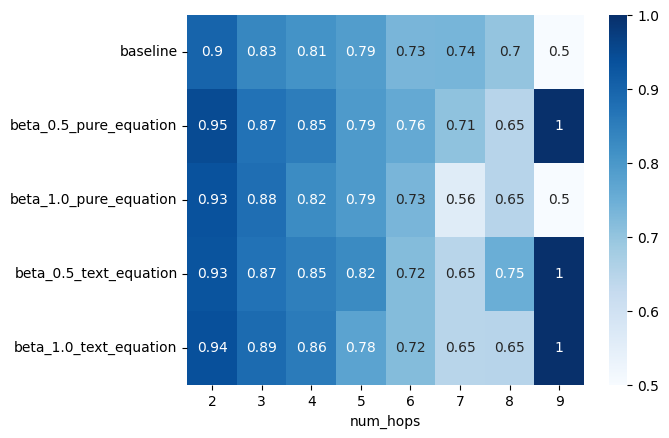

In [5]:

paths_to_compare = {
    "baseline": "results/results_microsoft-Phi-3.5-mini-instruct_.csv",
    "beta_0.5_pure_equation": "results/models-[beta1(0.5)-equation-without-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances-checkpoint-22_.csv",
    "beta_1.0_pure_equation": "results/models-[beta1(1)-equation-without-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances-checkpoint-22_.csv",
    "beta_0.5_text_equation": "results/models-[beta1(0.5)-equation-with-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances-checkpoint-22_.csv",
    "beta_1.0_text_equation": "results/models-[beta1(1)-equation-with-text]-[attn-ffn]-[16r-12alpha]-[lr1e-03-gradacum1]-[componly]-[rftdataonly]-qlora_rft_747instances-checkpoint-22_.csv",
}

datas = {k : pd.read_csv(v) for k, v  in paths_to_compare.items()}

performances_by_hop_length = {}

for k, v in datas.items(): 
    mean_ = v["maj_1s"].mean()

    v["num_hops"] = v["ground_truth_completions"].apply(lambda x: utils.GSM8KParser.get_num_hops(x)["num_hops"])
    performances_by_hop_length[k] = v.groupby("num_hops")["maj_1s"].mean()

    print(f"### Dataset:{k}\n### Mean Maj@1 {mean_}")
    print()

performances_by_hop_length_df = pd.DataFrame.from_dict(performances_by_hop_length)
sns.heatmap(performances_by_hop_length_df.T, annot=True, cmap="Blues", )

## Evaluate the model trained on a Union of two datasets 


Though weighted joint training is marginally better then naive joint training, the same observation follows that the model's performance declines as the number of required hops increases. 

### Dataset:baseline
### Mean Maj@1 0.8257575757575758

### Dataset:joint-train-weighted
### Mean Maj@1 0.8156565656565656

### Dataset:joint-train-unweighted
### Mean Maj@1 0.8005050505050505



<Axes: xlabel='num_hops'>

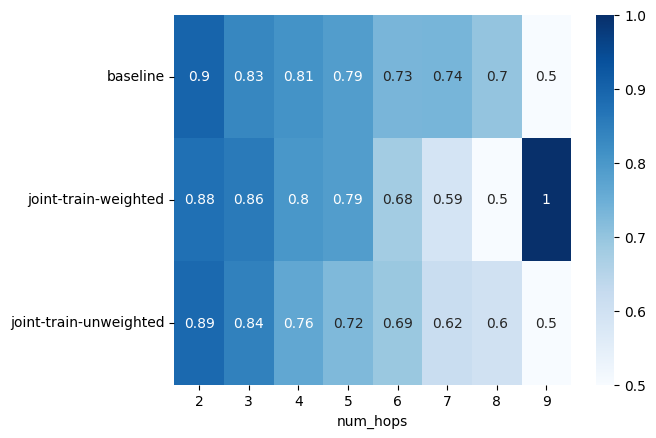

In [6]:
paths_to_compare = {
    "baseline": "results/results_microsoft-Phi-3.5-mini-instruct_.csv",
    "joint-train-weighted": "results/[attn-ffn]-lora-32r-25alpha-componly-uniondata-weighted-equationwithoutext-qlora_rft_747instances-checkpoint-117-_.csv",
    "joint-train-unweighted": "results/results_models-[attn-ffn]-lora-32r-25alpha-componly-uniondata-qlora_rft_747instances-checkpoint-117_.csv",
}

datas = {k : pd.read_csv(v) for k, v  in paths_to_compare.items()}

performances_by_hop_length = {}

for k, v in datas.items(): 
    mean_ = v["maj_1s"].mean()

    v["num_hops"] = v["ground_truth_completions"].apply(lambda x: utils.GSM8KParser.get_num_hops(x)["num_hops"])
    performances_by_hop_length[k] = v.groupby("num_hops")["maj_1s"].mean()

    print(f"### Dataset:{k}\n### Mean Maj@1 {mean_}")
    print()

performances_by_hop_length_df = pd.DataFrame.from_dict(performances_by_hop_length)
sns.heatmap(performances_by_hop_length_df.T, annot=True, cmap="Blues", )

# [Optional] - Discussion

We would be interested to know:

1.   If you were less time / computationally constrained, what would you do differently?

First of all, I want to spend more time making the equation parser better to support multi-line cases and be more restrictive on selecting the text span before and after the equation.

Then, I would like to perform deeper evaluation on the fine-tuned model vs the baseline model to better understand the failure modes. Comparing the failed and succeeded generations, trying to understand what's missing from the generated data.

Afterthat, I would run the evaluation on the entire test dataset and also try to include the maj@1 metric for us to observe during training. The loss function for code generation and math reasoning is usually only a source of reference, which could be misleading sometimes. For those problems, only a critical span of tokens really matters and the loss function could almost only tells you if the model has learned the "vibe" of the intended text. Thus a hard metric is more likely to give us the confirmation that a model has learned. Incoporating (Gold-fish)[https://arxiv.org/pdf/2406.10209] loss could also be interesting to play with. 

Last but not least, I am quite interested in trying another approach in selecting the curriculum/questions to participate the rejection sampling, that is $p(1-p)$, $p$ being the probability of successfully solving a question given a number of attempts. The intuition is simple, if I want to prioritize the questions which I am the most uncertain about. This approach has recently got some success in sampling Reinforcement Learning environments for Unsupervised Environment Design (https://arxiv.org/pdf/2408.15099).


2.   What would your ideal first project look like if you joined?

